In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Read the dataset from CSV File
data = pd.read_csv('data.csv')
data.head(5)

,Unnamed: 0,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


In [3]:
#Dividing dataset into features and result
#Put Features into X
X = data[['location', 'country', 'gender', 'age', 'vis_wuhan', 'from_wuhan', 'symptom1', 'symptom2', 'symptom3', 'symptom4', 'symptom5', 'symptom6', 'diff_sym_hos']]
print(X.shape)
X.head(5)

#Hot Encoding
X_hot = pd.get_dummies(X, columns=['location', 'country','gender', 'age', 'symptom1', 'symptom2', 'symptom3', 'symptom4', 'symptom5', 'symptom6', 'diff_sym_hos'])
print(X_hot.shape)
print(X_hot.head(5))

(863, 13)
(863, 373)
   vis_wuhan  from_wuhan  ...  diff_sym_hos_14  diff_sym_hos_15
0          1           0  ...                0                0
1          0           1  ...                0                0
2          0           1  ...                0                0
3          1           0  ...                0                0
4          0           0  ...                0                0

[5 rows x 373 columns]


In [4]:
#Labeled Data
Y = data['result']
print(Y.shape)
Y.head()

(863,)


0    1
1    0
2    0
3    0
4    0
Name: result, dtype: int64

In [5]:
#splite the data into Train and Test by 90% for training to 10% for testing
xTrain, xTest, yTrain, yTest = train_test_split(X_hot, Y, test_size = .1, random_state = 3, shuffle = True)
print(xTrain.shape)
print(xTest.shape)
print(yTrain.shape)
print(yTest.shape)

(776, 373)
(87, 373)
(776,)
(87,)


In [7]:
#normalize the data values
scaler = StandardScaler()
scaler.fit(xTrain)
xTrain=scaler.transform(xTrain)
xTest=scaler.transform(xTest)

In [8]:
initial_n_neighbors_value = np.random.randint(1 , 30)
classifier = KNeighborsClassifier(n_neighbors = initial_n_neighbors_value, metric = 'minkowski', p = 2)

In [9]:
k_range = list(range(3, 31, 2))
print(k_range)

[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]


In [10]:
#GrideSearchCV to find the optimal hyperparameters by fit alot of models with difrrent hyperparameters and chose the best one with high accuracy
param_grid = {'n_neighbors': k_range, 'weights': ['uniform', 'distance']}
grid = GridSearchCV(classifier, param_grid, cv=10, scoring='accuracy')
grid.fit(xTrain, yTrain)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_neighbors=28),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                         25, 27, 29],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [11]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.9045621045621047
{'n_neighbors': 3, 'weights': 'distance'}
KNeighborsClassifier(n_neighbors=3, weights='distance')


In [12]:
#train the model with optimal hyperparameters
knn = KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = 2, weights='distance')
knn.fit(xTrain, yTrain)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [13]:
#test the accuracy of model on training set
print('KNN Model Train Score is : ' , knn.score(xTrain, yTrain))

KNN Model Train Score is :  1.0


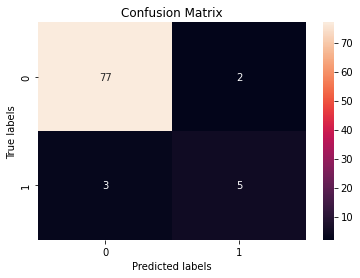

In [14]:
#Calculating Prediction
yPred = knn.predict(xTest)
#----------------------------------------------------
#Calculating Confusion Matrix
CM = confusion_matrix(yTest, yPred)

# drawing confusion matrix
ax= plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

In [15]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set:

ClassificationReport = classification_report(yTest, yPred)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97        79
           1       0.71      0.62      0.67         8

    accuracy                           0.94        87
   macro avg       0.84      0.80      0.82        87
weighted avg       0.94      0.94      0.94        87



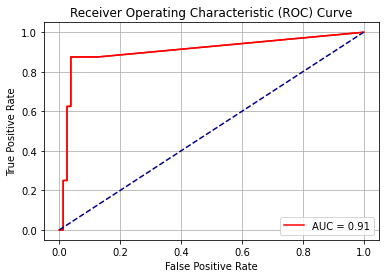

In [17]:
#Calculating Area Under the Curve with predict probapility:
fpr, tpr, thresholds = roc_curve(yTest, knn.predict_proba(xTest)[:,1])

roc_auc = roc_auc_score(yTest, knn.predict_proba(xTest)[:,1])
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr, tpr, color='red', label='')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.grid()